# Multilabel Classification

In multi-label classification, each sample can have multiple labels associated with it, as opposed to the traditional single-label classification where each sample can have only one label associated with it. <br/>

This means that the output of a multi-label classifier is an array of probabilities, one for each label, indicating the probability of the input sample belonging to each label.

# Setting Up

In [ ]:
!nvidia-smi

Sun Jan 11 05:31:01 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%matplotlib inline

In [ ]:
! pip install -q transformers[sentencepiece] fastbook fastai nbdev plum-dispatch evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.3 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/msi1427/blurr.git
%cd blurr

Cloning into 'blurr'...
remote: Enumerating objects: 5063, done.
remote: Counting objects: 100% (894/894), done.
remote: Compressing objects: 100% (311/311), done.
remote: Total 5063 (delta 705), reused 702 (delta 576), pack-reused 4169 (from 1)
Receiving objects: 100% (5063/5063), 26.85 MiB | 17.04 MiB/s, done.
Resolving deltas: 100% (3934/3934), done.
/content/blurr


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Datasets/NLP

/content/drive/My Drive/Datasets/NLP


# Data Preprocessing and visualization

In [ ]:
df = pd.read_csv("/content/news_multilabel_merged.csv")
df.head()

,title,text,labels,source,url,section
0,Starmer faces rebellion over plan to cut jury trials,"Nearly 40 Labour MPs have warned the prime minister they are not prepared to support proposals to limit jury trials in England and Wales. In a letter to Sir Keir Starmer, MPs largely from the left of the party said restricting juries to major offences carrying three-year terms was ""madness and will cause more problems than it solves"". Former shadow attorney general Karl Turner, who organised the letter, said he will vote against Labour for the first time since Sir Keir took charge, branding the plans ""simply unworkable"". The government insisted it would go ahead with the plans, adding they...",['Politics'],BBC,https://www.bbc.com/news/articles/c93w771g14go,NaN
1,UK to ban deepfake AI 'nudification' apps,"The UK government says it will ban so-called ""nudification"" apps as part of efforts to tackle misogyny online. New laws - announced on Thursday as part of a wider strategy to halve violence against women and girls - will make it illegal to create and supply AI tools letting users edit images to seemingly remove someone's clothing. The new offences would build on existing rules around sexually explicit deepfakes and intimate image abuse, the government said. ""Women and girls deserve to be safe online as well as offline,"" said Technology Secretary Liz Kendall. ""We will not stand by while tec...",['Politics'],BBC,https://www.bbc.com/news/articles/cq8dp2y0z7wo,NaN
2,Scotland Politics | Latest News & Updates | BBC News,The Scottish parliament's presiding officer says the incident was part of an employment dispute involving an MSP. Their union BMA Scotland has accused the government of reneging on a commitment to restore pay to 2008 levels. Opposition party leaders grilll John Swinney in the final First Minister's Questions before Christmas Why did the people of Whitburn - and nearby Blackburn - choose Nigel Farage's party over others? The delivery date for MV Glen Rosa is pushed back by up to another six months while there is a further short delay with the Turkish-built Isle of Islay. The first minister ...,['Politics'],BBC,https://www.bbc.com/news/scotland/scotland_politics,NaN
3,Foreign prison officers exempted from new stricter visa rules,"Foreign nationals working as prison officers in the UK have been given a temporary exemption from new visa rules, following warnings some jails were facing a staffing crisis. Prisons have increasingly been relying on overseas recruits, particularly from Nigeria and Ghana. But organisations representing officers had warned jails faced losing thousands of staff, after the government increased the minimum salary requirement for a skilled worker visa. The Ministry of Justice said the move would ""ensure jails can continue to run safely with the right level of experienced staff"". Under changes i...",['Politics'],BBC,https://www.bbc.com/news/articles/cp89p1x26kxo,NaN
4,Batters review: 'Bewildered' farmers need new deal to be profitable,"Farmers are ""bewildered and frightened"" with many questioning the future of their businesses because of the government's proposed changes to inheritance tax, an independent review of farm profitability has found. The long-awaited government-commissioned report was published on Thursday with 57 recommendations designed to improve productivity, investment and resilience in agriculture. But author Baroness Minette Batters, former president of the National Farmers' Union (NFU), warned there was ""no silver bullet"" to making farms in England profitable. Environment secretary Emma Reynolds said t...",['Politics'],BBC,https://www.bbc.com/news/articles/c9975z55dr5o,NaN


In [ ]:
df.shape

(95730, 6)

In [ ]:
df = df.dropna().reset_index(drop=True)
df.shape

(92330, 6)

In [ ]:
import ast
from collections import Counter

# 1. Prepare to count
label_count = Counter()

# 2. Iterate safely
for label_entry in df['labels']:
    # Convert string "[...]" to actual list safely
    if isinstance(label_entry, str):
        try:
            # We use a different variable name (current_labels) to avoid overwriting
            current_labels = ast.literal_eval(label_entry)
        except:
            continue
    else:
        current_labels = label_entry

    # Update our counter with the list of labels in this row
    if isinstance(current_labels, list):
        label_count.update(current_labels)

print(f"Number of unique labels: {len(label_count)}")
print(dict(label_count))

# 3. Calculate threshold and rare labels
threshold = int(len(df) * 0.01)
rare_labels = [key for key, value in label_count.items() if value < threshold]

print(f"Threshold (1%): {threshold}")
print(f"Number of rare labels: {len(rare_labels)}")

Number of unique labels: 12
{'Politics': 50623, 'Technology': 32667, 'Business': 19669, 'Economy': 12410, 'Sports': 11, 'International_Affairs': 10040, 'Education': 5938, 'Health': 38, 'Energy': 34, 'Crime': 10, 'Science': 4927, 'Climate': 9972}
Threshold (1%): 923
Number of rare labels: 4


In [ ]:
import ast

# 1. Convert to a list of rows
raw_labels_list = df['labels'].to_list()
revised_label_list = []
indices_to_drop = []

for idx, item in enumerate(raw_labels_list):
    # Convert string "[...]" to actual list safely, or keep if already a list
    if isinstance(item, str):
        try:
            current_row_labels = ast.literal_eval(item)
        except:
            current_row_labels = []
    else:
        current_row_labels = item

    # Filter the labels
    # Use a different name (l) to avoid shadowing the list
    revised_row = [l for l in current_row_labels if l not in rare_labels]

    # Check if any labels are left
    if len(revised_row) == 0:
        indices_to_drop.append(idx)
    else:
        revised_label_list.append(revised_row)

# 2. Update the DataFrame
df = df.drop(indices_to_drop).reset_index(drop=True)
df['revised_labels'] = revised_label_list

print(f"Original rows dropped: {len(indices_to_drop)}")
print(f"New shape: {df.shape}")

Original rows dropped: 36
New shape: (92294, 7)


In [ ]:
revised_label_list = df.revised_labels.to_list()
revised_label_count = {}
for labels in revised_label_list:
  label_list = labels
  for label in label_list:
    if label in revised_label_count.keys():
      revised_label_count[label] += 1
    else:
      revised_label_count[label] = 1
print(f"Number of labels: {len(revised_label_count)}")

Number of labels: 8


In [ ]:
encode_label_types = { key: idx for idx, (key, value) in enumerate(revised_label_count.items())}
with open("label_types_encoded-v2.json", "w") as fp:
  json.dump(encode_label_types, fp)

In [ ]:
labels = list(encode_label_types.keys())
len(labels), labels

(8,
 ['Politics',
  'Technology',
  'Business',
  'Economy',
  'International_Affairs',
  'Education',
  'Science',
  'Climate'])

In [ ]:
import json
from collections import Counter

# Count all occurrences to build the dictionary
all_labels = [label for sublist in df.revised_labels for label in sublist]
label_counts = Counter(all_labels)

# Create the mapping: {"Politics": 0, "Technology": 1, ...}
encode_label_types = { key: idx for idx, key in enumerate(label_counts.keys())}

# Save it for later use in your model/inference
with open("label_types_encoded.json", "w") as fp:
    json.dump(encode_label_types, fp)

In [ ]:
df.head()

,title,text,labels,source,url,section,revised_labels
0,‘It’s rather rude’: Truss accused of trying to poach members of rival Tory club,"For Tory grandees licking their wounds and plotting their return after their disastrous 2024 general election performance, the opulent, fire-lit rooms of the exclusive club 5 Hertford Street are a sanctuary. But in recent weeks, their long lunches have been rudely interrupted by Liz Truss, who has been accused of wandering the premises in search of members to poach for her own rival operation, just one street away, which asks “founding members” for an eye-watering £500,000. The former prime minister’s alleged headhunting is understood to have irritated those who run the Mayfair club, inclu...",['Politics'],Guardian,https://www.theguardian.com/politics/2025/dec/19/tory-members-club-accuses-liz-truss-of-poaching-tactics,politics,[Politics]
1,"UK politics: ‘Not clear’ who was behind FCDO hack, says minister, amid reports of China link – as it happened","We are closing this blog soon. For the latest in UK news, follow our coverage here. The UK’s Foreign, Commonwealth and Development Office was hacked in October. Details of the hack emerged on Friday in a report by the Sun that claimed a Chinese hacker group was behind the cyber-attack. The Sun named Storm 1849 as the Chinese cyber gang responsible for the breach, which it said was understood to possibly include tens of thousands of visa details. However, when asked if China was behind the attack, trade minister Chris Bryant told broadcasters it was “not clear” who perpetrated the attack an...",['Politics'],Guardian,https://www.theguardian.com/politics/live/2025/dec/19/labour-reform-conservatives-tories-lib-dems-uk-politics-latest-news-updates,politics,[Politics]
2,"UK Foreign Office victim of cyber-attack in October, says Chris Bryant","The UK’s Foreign, Commonwealth and Development Office was hacked in October, a minister has said. Chris Bryant, a trade minister in Keir Starmer’s government, told Sky News there was a low risk to “any individual” from the cyber-attack. Details of the hack emerged on Friday in a report by the Sun that claimed a Chinese hacking group was behind it. But Bryant told broadcasters it was “not clear” who perpetrated the attack and cautioned against speculation. “There certainly has been a hack at the FCDO and we’ve been aware of that since October,” Bryant told Sky News. The Sun named Storm 1849...",['Politics'],Guardian,https://www.theguardian.com/technology/2025/dec/19/uk-foreign-office-victim-cyber-attack-october-,politics,[Politics]
3,Society of Editors decries Starmer’s plan to reduce media scrutiny of No 10,"The Society of Editors has raised concerns about Keir Starmer’s plan to reduce scrutiny of No 10 by political journalists, saying it risks weakening transparency. The body, which represents news organisations, said regular, open and robust questioning was a cornerstone of democracy and that the plan to reduce briefings was deeply concerning. Downing Street’s director of communications, Tim Allan, unveiled the plan on Thursday without consulting the group of political journalists known as the lobby who traditionally attend briefings twice a day to question the prime minister’s spokesperson....",['Politics'],Guardian,https://www.theguardian.com/politics/2025/dec/19/society-of-editors-starmer-plan-reduce-lobby-briefing-media-scrutiny,politics,[Politics]
4,Reform-run Kent council accused of blocking scrutiny of claim it saved £40m,"Reform-run Kent council has been accused of trying to block scrutiny after it refused, for more than five months, to produce evidence that it had saved more than £40m by cancelling two environmental projects that did not exist yet. Polly Billington, a Labour MP in Kent, first requested background to the claim via a freedom of information (FoI) request in July. She said the subsequent delay had not been explained and seemed to show the council was embarrassed at what the documents would s

In [ ]:
categorical_label_list = []
num_classes = len(encode_label_types)
revised_labels_list = df.revised_labels.to_list()

for row_labels in revised_labels_list:
    # 1. Create a fresh list of zeros for THIS row
    categorical_vector = [0] * num_classes

    # 2. Fill with 1s where the label exists
    for label in row_labels:
        if label in encode_label_types:
            index = encode_label_types[label]
            categorical_vector[index] = 1

    # 3. Add this row's vector to our master list
    categorical_label_list.append(categorical_vector)

# 4. Add the new column to your dataframe
df['label_cat_list'] = categorical_label_list
print(f"Dataset shape: {df.shape}")
print(f"Encoded vector length: {len(df['label_cat_list'].iloc[0])}")

Dataset shape: (92294, 8)
Encoded vector length: 8


In [ ]:
df.tail()

,title,text,labels,source,url,section,revised_labels,label_cat_list
92289,On my radar: Jade Anouka’s cultural highlights,"Jade Anouka is a London-based actor and poet. Since graduating from the Guildford School of Acting, she has starred in stage and screen productions including Phyllida Lloyd’s all-female Shakespeare trilogy, Channel 4’s Chewing Gum and the ITV drama Trauma. In 2016, she published a collection of poetry, Eggs on Toast, and last year gave a TEDx talk, Being Black, Being a Woman, Being “Other”. Anouka stars in a new six-part series Cleaning Up opposite Sheridan Smith on ITV from 9 January. 1. Restaurant Nandine This is in Camberwell, south-east London, near my house, so I go there a lot. It’s ...",['Technology'],Guardian,https://www.theguardian.com/culture/2019/jan/06/on-my-radar-jade-anouka-janelle-monae-david-attenborough,culture,[Technology],"[0, 1, 0, 0, 0, 0, 0, 0]"
92290,"New talent: the rising stars of culture, science and food 2019","Film: Harry Wootliff Leeds-born writer and director Harry Wootliff’s journey into film-making came via a stint as a performer: she trained as a dancer and actor before turning her attention to writing. Things clicked into place when she made her first short, Nits, a multi-award winning heart-tug of a film that earned a prestigious slot in Cannes. “I remember standing on set, looking at the actress and thinking, this is perfect,” she says. “I get to act through someone else. I don’t have to be the focus. It was a revelation really.” It’s perhaps because of her experience as an actor that Wo...",['Politics'],Guardian,https://www.theguardian.com/culture/2019/jan/06/the-observer-rising-stars-of-2019-film-music-art-activism-food-books,culture,[Politics],"[1, 0, 0, 0, 0, 0, 0, 0]"
92291,What to see this week in the UK,"Five of the best ... films The Favourite (15) (Yorgos Lanthimos, 2018, Ire/UK/US) 119 mins Three great performances – from Olivia Colman, Rachel Weisz and Emma Stone – ballast this brilliant fable of jostling power brokers at the 18th-century court of Queen Anne. Colman’s Anne has been garnering attention and will likely be a contender for big awards – but Stone (Abigail) and, particularly, Weisz (Sarah), as the favourites new and old, don’t deserve to be overshadowed. Mary Poppins Returns (U) (Rob Marshall, 2018, US) 130 mins This freshly scrubbed and sparkling update of Disney’s family f...",['Technology'],Guardian,https://www.theguardian.com/culture/2019/jan/04/what-to-see-this-week-in-the-uk,culture,[Technology],"[0, 1, 0, 0, 0, 0, 0, 0]"
92292,Hundreds of thousands spent on repairing art owned by government,"Hundreds of thousands of pounds of taxpayers’ money has been spent repairing artworks owned by the government that were damaged or needed restoration. Restorers were called in to fix 396 pieces in the government’s art collection in two years, according to figures obtained by the Guardian using freedom of information laws. The Department for Digital, Culture, Media and Sport (DCMS) said £212,871 had been spent repairing artworks since 2016. The Government Art Collection, which was established in 1898, includes a selection of historical, modern and contemporary British art that is on display...",['Politics'],Guardian,https://www.theguardian.com/culture/2019/jan/03/hundreds-of-thousands-spent-on-repairing-art-owned-by-government,culture,[Politics],"[1, 0, 0, 0, 0, 0, 0, 0]"
92293,Culture awards must go to Britain’s most deprived towns | Letters,"I read with interest your support for Yvette Cooper et al and their proposal for a town of culture (Editorial, 31 December). While mentioning just Oldham and Margate as towns that have developed a cultural footprint despite having suffered urban decline, the citing of Aldeburgh, Hay-on-Wye, Wigtown and Stroud as the other four likely contenders surely misses the point. While the UK’s major cities have all reinvented themselves as cultural destinations over the past 30 years or so, their neighbouring (often former indu

# **Model: distilroberta-base**

## Dataloaders and Modeling

In [ ]:
labels = list(encode_label_types.keys())
print(len(labels), labels)

8 ['Politics', 'Technology', 'Business', 'Economy', 'International_Affairs', 'Education', 'Science', 'Climate']


In [ ]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader('label_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [ ]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "dls-multilabel-book-classifier.pkl")

In [ ]:
# dls = torch.load("dataloaders/dls-multilabel-book-classifier.pkl")

In [ ]:
dls.vocab

['Politics', 'Technology', 'Business', 'Economy', 'International_Affairs', 'Education', 'Science', 'Climate']

In [ ]:
doc(accuracy_multi)

In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

##Stage - 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0010000000474974513, valley=0.00015848931798245758)

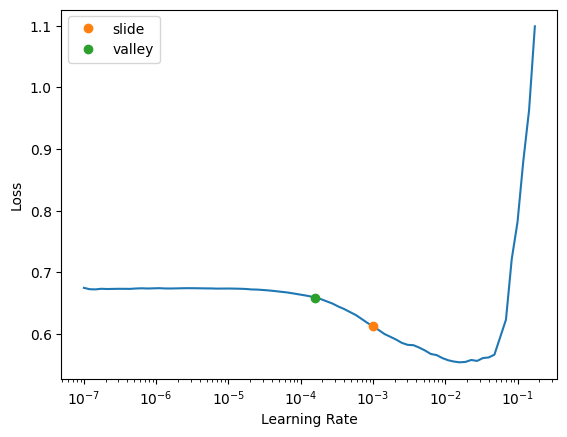

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(5,4.75e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.187734,0.184820,0.905745,14:03
1,0.169635,0.164272,0.906734,14:07
2,0.157690,0.155550,0.919439,14:10
3,0.151844,0.149548,0.917976,14:10
4,0.150466,0.147889,0.918355,14:05


In [ ]:
learner.save("news-final-classifier-stage")

Path('models/news-final-classifier-stage.pth')

In [ ]:
learner.export("news-final-classifier-stage.pkl")

## Stage - 1

In [ ]:
learner.load("news-final-classifier-stage")

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.0014454397605732083, valley=3.630780702224001e-05)

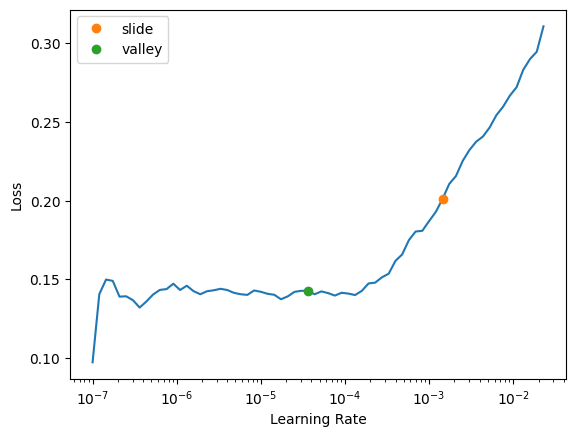

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(5,slice(4.75e-3, 2.25e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.173076,0.164646,0.917908,18:06
1,0.309824,0.292552,0.828029,17:48
2,0.284128,0.306311,0.843835,17:45
3,0.245922,0.278696,0.850322,18:12
4,0.228058,0.259312,0.872440,18:30


In [ ]:
learner.save("news-classifier-stage-1")

Path('models/news-classifier-stage-1.pth')

In [ ]:
learner.export("news-classifier-stage-final-version.pkl")

# **# ✅ MODEL-2: BERT-base-uncased**

## data loader and mdoeling

In [ ]:
labels = list(encode_label_types.keys())
print(len(labels), labels)

8 ['Politics', 'Technology', 'Business', 'Economy', 'International_Affairs', 'Education', 'Science', 'Climate']


In [ ]:
model_name = "bert-base-uncased"
model_cls = AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)
config.problem_type = "multi_label_classification"


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    model_name,
    model_cls=model_cls,
    config=config
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
blocks = (
    TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
    MultiCategoryBlock(encoded=True, vocab=labels)
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label_cat_list"),
    splitter=RandomSplitter(valid_pct=0.1, seed=42)
)


In [ ]:
df.head()

,title,text,labels,source,url,section,revised_labels,label_cat_list
0,‘It’s rather rude’: Truss accused of trying to poach members of rival Tory club,"For Tory grandees licking their wounds and plotting their return after their disastrous 2024 general election performance, the opulent, fire-lit rooms of the exclusive club 5 Hertford Street are a sanctuary. But in recent weeks, their long lunches have been rudely interrupted by Liz Truss, who has been accused of wandering the premises in search of members to poach for her own rival operation, just one street away, which asks “founding members” for an eye-watering £500,000. The former prime minister’s alleged headhunting is understood to have irritated those who run the Mayfair club, inclu...",['Politics'],Guardian,https://www.theguardian.com/politics/2025/dec/19/tory-members-club-accuses-liz-truss-of-poaching-tactics,politics,[Politics],"[1, 0, 0, 0, 0, 0, 0, 0]"
1,"UK politics: ‘Not clear’ who was behind FCDO hack, says minister, amid reports of China link – as it happened","We are closing this blog soon. For the latest in UK news, follow our coverage here. The UK’s Foreign, Commonwealth and Development Office was hacked in October. Details of the hack emerged on Friday in a report by the Sun that claimed a Chinese hacker group was behind the cyber-attack. The Sun named Storm 1849 as the Chinese cyber gang responsible for the breach, which it said was understood to possibly include tens of thousands of visa details. However, when asked if China was behind the attack, trade minister Chris Bryant told broadcasters it was “not clear” who perpetrated the attack an...",['Politics'],Guardian,https://www.theguardian.com/politics/live/2025/dec/19/labour-reform-conservatives-tories-lib-dems-uk-politics-latest-news-updates,politics,[Politics],"[1, 0, 0, 0, 0, 0, 0, 0]"
2,"UK Foreign Office victim of cyber-attack in October, says Chris Bryant","The UK’s Foreign, Commonwealth and Development Office was hacked in October, a minister has said. Chris Bryant, a trade minister in Keir Starmer’s government, told Sky News there was a low risk to “any individual” from the cyber-attack. Details of the hack emerged on Friday in a report by the Sun that claimed a Chinese hacking group was behind it. But Bryant told broadcasters it was “not clear” who perpetrated the attack and cautioned against speculation. “There certainly has been a hack at the FCDO and we’ve been aware of that since October,” Bryant told Sky News. The Sun named Storm 1849...",['Politics'],Guardian,https://www.theguardian.com/technology/2025/dec/19/uk-foreign-office-victim-cyber-attack-october-,politics,[Politics],"[1, 0, 0, 0, 0, 0, 0, 0]"
3,Society of Editors decries Starmer’s plan to reduce media scrutiny of No 10,"The Society of Editors has raised concerns about Keir Starmer’s plan to reduce scrutiny of No 10 by political journalists, saying it risks weakening transparency. The body, which represents news organisations, said regular, open and robust questioning was a cornerstone of democracy and that the plan to reduce briefings was deeply concerning. Downing Street’s director of communications, Tim Allan, unveiled the plan on Thursday without consulting the group of political journalists known as the lobby who traditionally attend briefings twice a day to question the prime minister’s spokesperson....",['Politics'],Guardian,https://www.theguardian.com/politics/2025/dec/19/society-of-editors-starmer-plan-reduce-lobby-briefing-media-scrutiny,politics,[Politics],"[1, 0, 0, 0, 0, 0, 0, 0]"
4,Reform-run Kent council accused of blocking scrutiny of claim it saved £40m,"Reform-run Kent council has been accused of trying to block scrutiny after it refused, for more than five months, to produce evidence that it had saved more than £40m by cancelling two environmental projects that did not exist yet. Polly Billington, a Labour MP in Kent, first requested background to the claim via a freedom of information (FoI) request in July. She sa

In [ ]:
dls = dblock.dataloaders(df, bs=32)

In [ ]:
model_bert = BaseModelWrapper(hf_model)


In [ ]:
acc_02 = partial(accuracy_multi, thresh=0.2)


In [ ]:
learner_bert = Learner(
    dls,
    model_bert,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[acc_02],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter
).to_fp16()


## Train-stage 0

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.242286,0.234154,0.868377,25:25
1,0.190357,0.193802,0.903782,25:26
2,0.179242,0.184249,0.905258,25:28
3,0.174763,0.178818,0.905055,25:31
4,0.176146,0.178416,0.905867,25:31


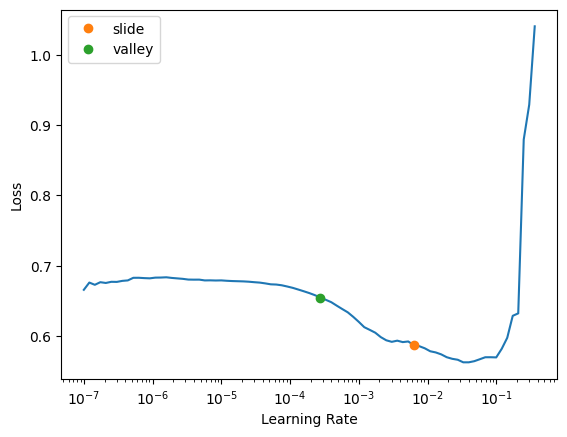

In [ ]:
learner_bert.freeze()
learner_bert.lr_find(suggest_funcs=[slide, valley])
learner_bert.fit_one_cycle(5, 3e-4)
learner_bert.save("bert-multilabel-stage0")
learner_bert.export("bert-multilabel-stage0.pkl")


## Stage-1

In [ ]:
learner_bert.load("bert-multilabel-stage0")

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.178625,0.178097,0.902725,25:29
1,0.173167,0.173867,0.908251,25:28
2,0.161631,0.171118,0.912992,25:29
3,0.166282,0.165314,0.913290,25:32
4,0.162525,0.164905,0.914996,25:27


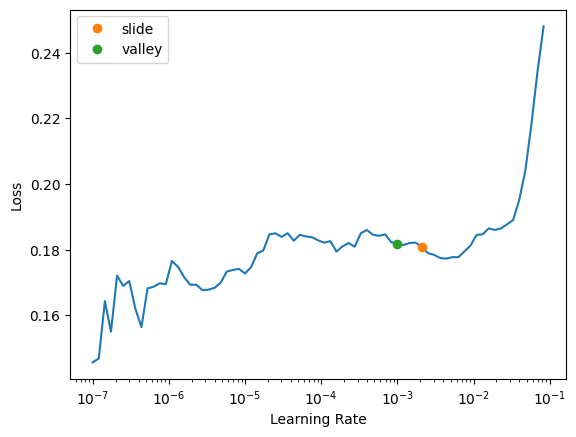

In [ ]:
learner_bert.freeze()
learner_bert.lr_find(suggest_funcs=[slide, valley])
learner_bert.fit_one_cycle(5, 3e-4)
learner_bert.save("bert-multilabel-stage1")
learner_bert.export("bert-multilabel-stage1.pkl")

# **🔹 MODEL-3: RoBERTa Base**

## Data Loader and modeling

In [ ]:
labels = list(encode_label_types.keys())
print(len(labels), labels)

8 ['Politics', 'Technology', 'Business', 'Economy', 'International_Affairs', 'Education', 'Science', 'Climate']


In [ ]:
model_name = "roberta-base"
model_cls = AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)
config.problem_type = "multi_label_classification"

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    model_name,
    model_cls=model_cls,
    config=config
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
blocks = (
    TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
    MultiCategoryBlock(encoded=True, vocab=labels)
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label_cat_list"),
    splitter=RandomSplitter(valid_pct=0.1, seed=42)
)


In [ ]:
dls = dblock.dataloaders(df, bs=32)

In [ ]:
model_bert = BaseModelWrapper(hf_model)

In [ ]:
acc_02 = partial(accuracy_multi, thresh=0.2)

In [ ]:
learner_bert = Learner(
    dls,
    model_bert,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[acc_02],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter
).to_fp16()


## stage-0

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.194397,0.188078,0.892960,25:34
1,0.170986,0.165887,0.914007,25:38
2,0.157643,0.155782,0.911475,25:39
3,0.152559,0.150641,0.916527,25:40
4,0.153867,0.149596,0.916974,25:41


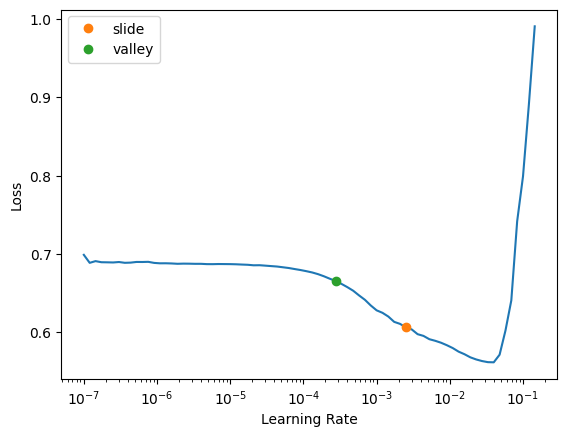

In [ ]:
learner_bert.freeze()
learner_bert.lr_find(suggest_funcs=[slide, valley])
learner_bert.fit_one_cycle(5, 3e-4)
learner_bert.save("roberta base-multilabel-stage0")
learner_bert.export("roberta base-multilabel-stage0.pkl")

## stage-1

In [ ]:
learner_bert.load("roberta base-multilabel-stage0")

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.156513,0.150726,0.916527,25:41
1,0.150979,0.146025,0.919154,25:39
2,0.144276,0.140825,0.925872,25:38
3,0.121383,0.138698,0.927904,25:39
4,0.130999,0.137804,0.926942,25:38


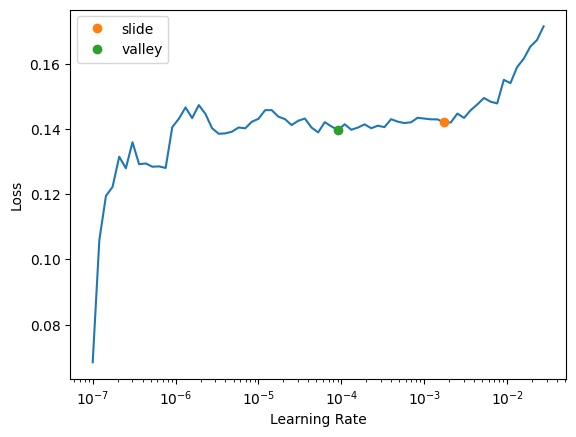

In [ ]:
learner_bert.freeze()
learner_bert.lr_find(suggest_funcs=[slide, valley])
learner_bert.fit_one_cycle(5, 3e-4)
learner_bert.save("roberta base-multilabel-stage1")
learner_bert.export("roberta base-multilabel-stage1.pkl")